# House Prices Regression - EDA and Models
**The Analytics Club** || Center for Innovation, IIT Madras

In this notebook, I will analyze a dataset of house prices from a locality. We will look at feature distributions and try to perceive their effect on prices (target). Based on patterns observed we will generate some new features. Finally, I present the model I used for my final submission and another model for comparison.  

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import probplot
import seaborn as sns
import folium
from folium.plugins import HeatMap
plt.style.use('seaborn')
from tqdm.notebook import tqdm
import datetime as dt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from IPython.display import clear_output

In [2]:
# Import data
train = pd.read_csv('.././data/train.csv', parse_dates=['date'])
test = pd.read_csv('.././data/test.csv', parse_dates=['date'])

## **Features and Trends**
In this section, some features have been generated and their behavior with price has been observed. This will help us to choose good features and generate new ones with these chosen features.  

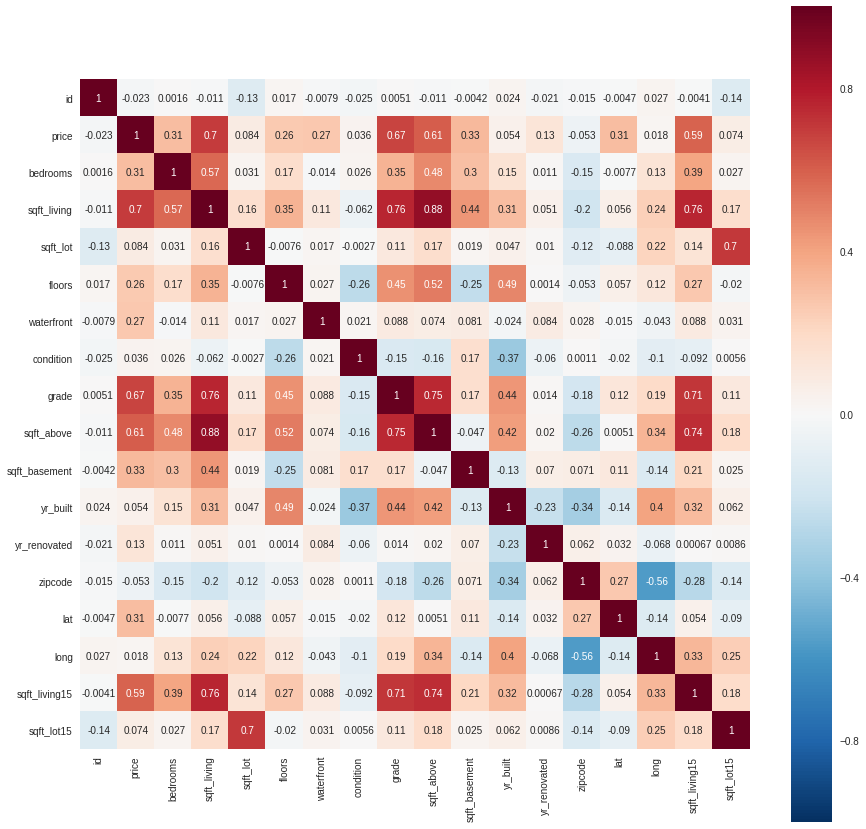

In [11]:
# Correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(train.corr(), square=True, annot=True, cmap='RdBu_r', vmin=-1.0, vmax=1.0)
plt.show()

Living area, number of bedrooms, grade, area above and living area in 2015 strongly affect the price. Other weak indicators include number of bedrooms, number of floors, waterfront, basement area and location (latitude). Surprisingly condition doesn't affect the price much. Perhaps because condition will improve when people live there, and degrade when the house is abandoned so tenants don't care about the current state of the house. `Condition` is a tricky feature to understand. It is negatively correlated with grade, and living area. It doesn't seem to affect the price. Larger values of `yr_built` (newer houses) have lower conditions. Perhaps it's not a good feature.

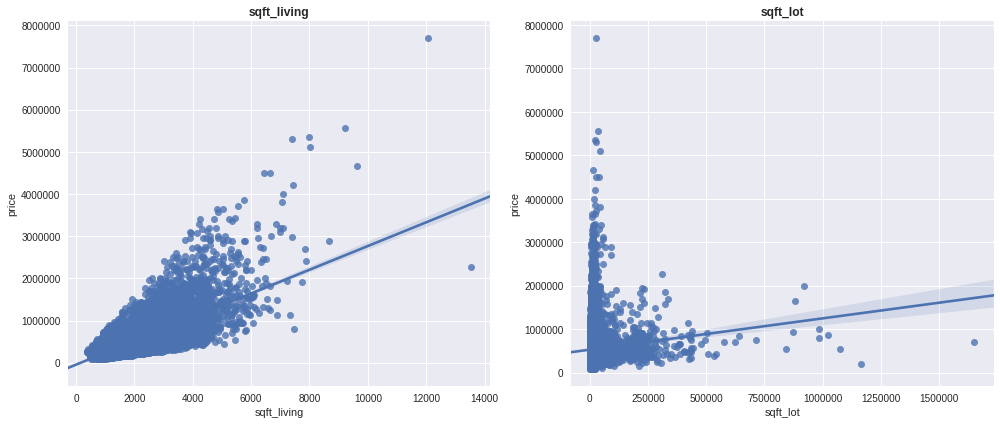

In [26]:
# Lot and living areas
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.regplot(x='sqft_living', y='price', data=train)
ax1.set_title('sqft_living', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.regplot(x='sqft_lot', y='price', data=train)
ax2.set_title('sqft_lot', fontweight='bold')
plt.tight_layout()
plt.show()

Living area has a clear rising trend with price, with few outliers. Interestingly all house prices are enveloped by a regioin between two lines. Could there be a restriction on the price for a house (like an MRP)? Either way, this tells us that simple linear regression won't do, since many houses with the same area have varying prices. Lot area doesn't have strong trend with price. Another thing to notice is the amount of uncertainty (standard error) for these regressions, which is higher for lot area (and quite small for living area).

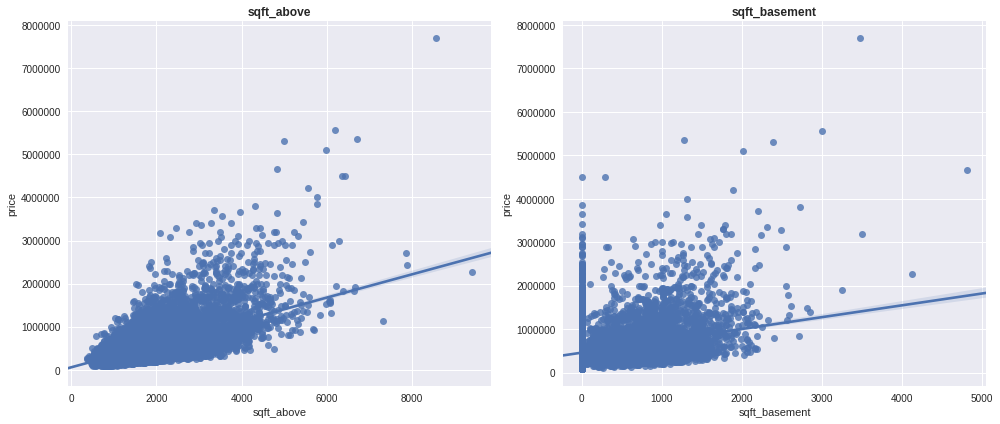

In [27]:
# Above and basement areas
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.regplot(x='sqft_above', y='price', data=train)
ax1.set_title('sqft_above', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.regplot(x='sqft_basement', y='price', data=train)
ax2.set_title('sqft_basement', fontweight='bold')
plt.tight_layout()
plt.show()

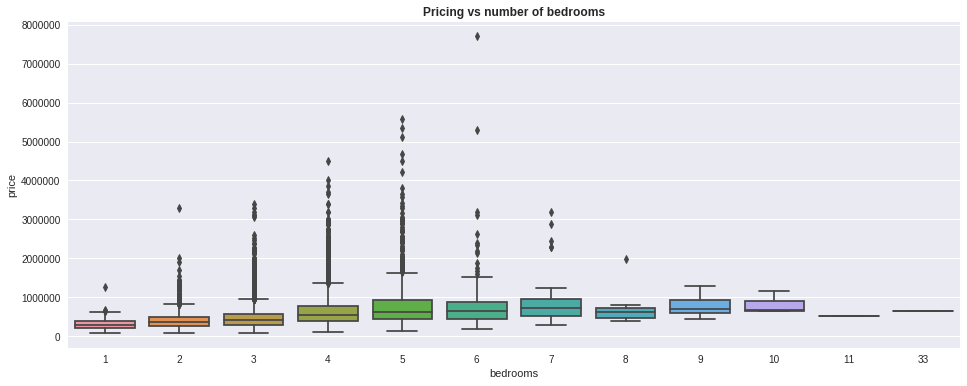

In [15]:
# Pricing vs number of bedrooms
plt.figure(figsize=(16, 6))
sns.boxplot(y='price', x='bedrooms', data=train)
plt.title('Pricing vs number of bedrooms', fontweight='bold')
plt.show()

Rooms with more bedrooms are priced relatively higher, but this trend saturates beyond 6 bedrooms. And the one with 33 bedrooms is probably a hotel or guest house of sorts. What will one family do with 33 beds?

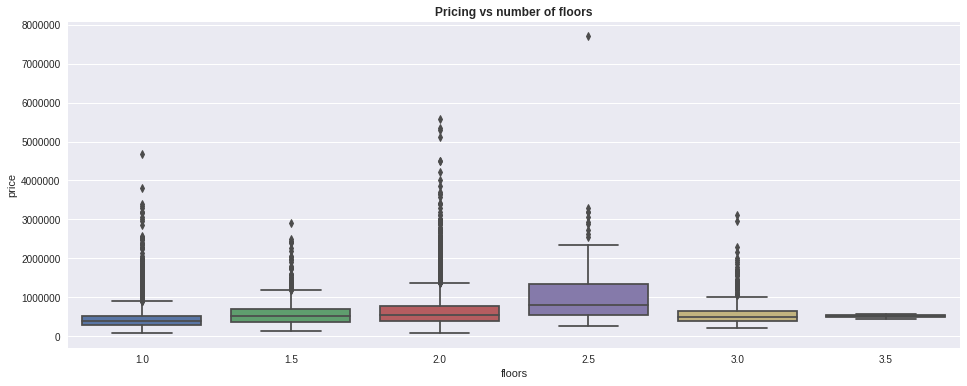

In [17]:
# Pricing vs number of floors
plt.figure(figsize=(16, 6))
sns.boxplot(y='price', x='floors', data=train)
plt.title('Pricing vs number of floors', fontweight='bold')
plt.show()

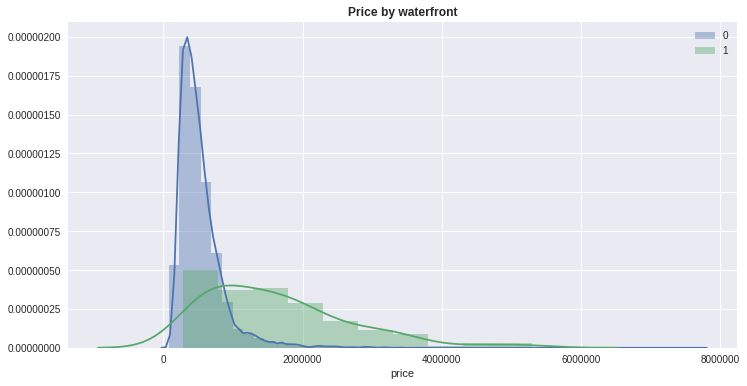

In [22]:
# Effect of waterfront on price
plt.figure(figsize=(12, 6))
for val in train['waterfront'].unique():
    sns.distplot(train[train['waterfront']==val]['price'], hist=True, kde=True, label=val)
plt.title('Price by waterfront', fontweight='bold')
plt.legend()
plt.show()

Houses with a waterfront are priced higher in general than those without.

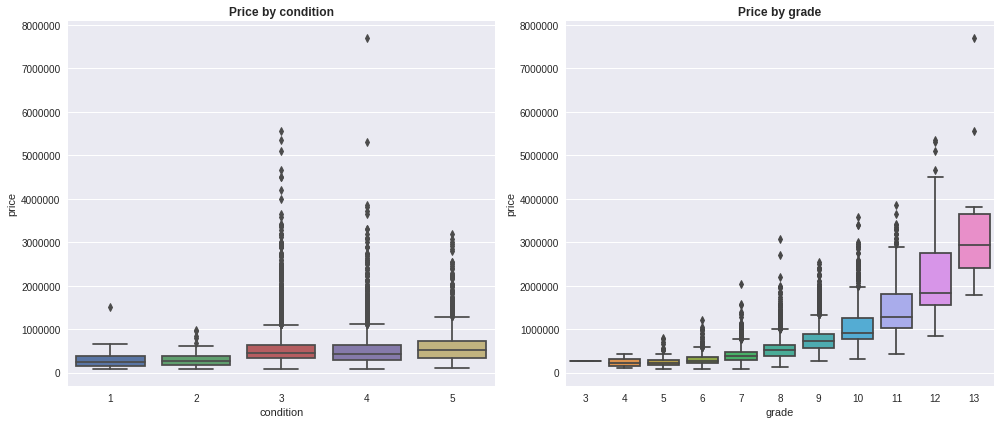

In [25]:
# Price by grade and condition
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.boxplot(y='price', x='condition', data=train)
ax1.set_title('Price by condition', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.boxplot(y='price', x='grade', data=train)
ax2.set_title('Price by grade', fontweight='bold')
plt.tight_layout()
plt.show()

It is clearly visible here that condition is a poor inidicator of price while grade is a really strong indicator of price. 

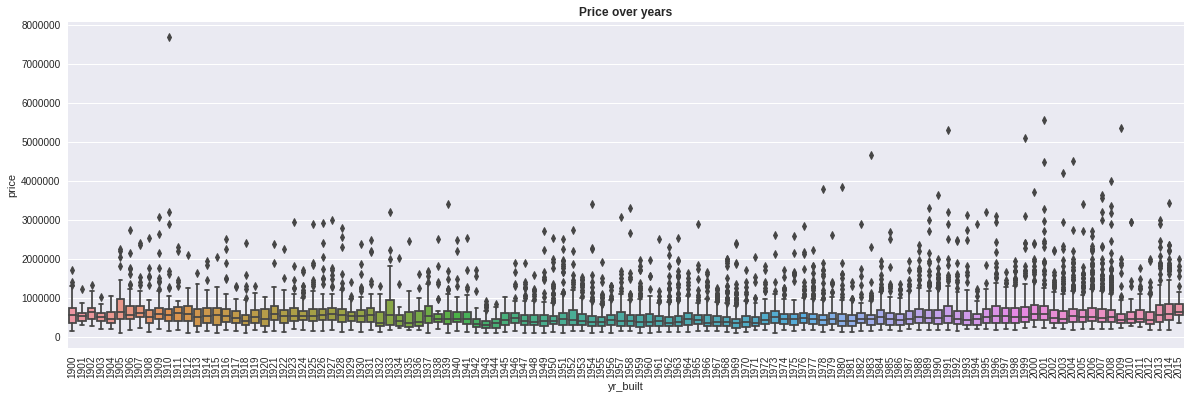

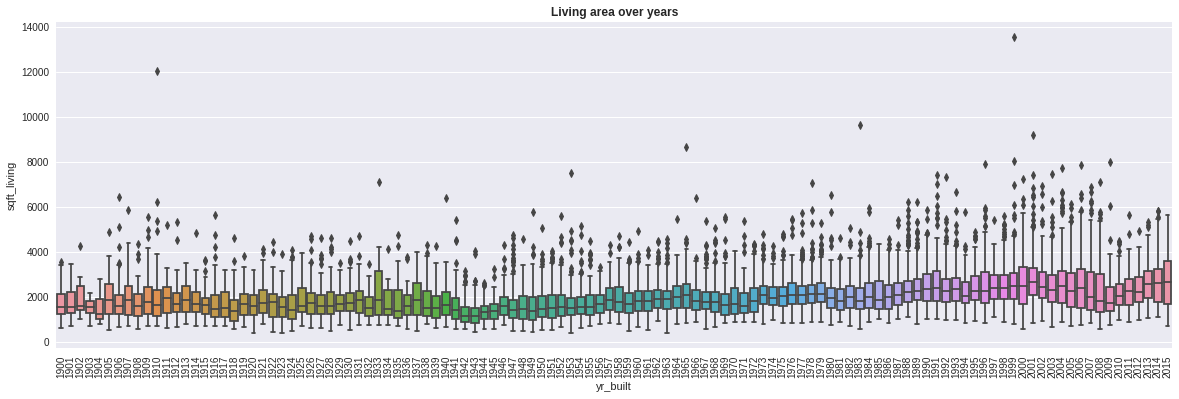

In [33]:
# Price variation along years
plt.figure(figsize=(20, 6))
sns.boxplot(y='price', x='yr_built', data=train)
plt.xticks(rotation=90)
plt.title('Price over years', fontweight='bold')
plt.show()

# Living area over years
plt.figure(figsize=(20, 6))
sns.boxplot(y='sqft_living', x='yr_built', data=train)
plt.xticks(rotation=90)
plt.title('Living area over years', fontweight='bold')
plt.show()

Living area and pricing for houses haven't changed remarkably with age, but are slightly higher for newer houses. 

In [50]:
# Map distribution of prices
# Adapted from a Kaggle kernel I read sometime earlier
train_copy = train.copy()
train_copy['price_minus_mean'] = train_copy['price'] - train_copy['price'].mean()
lat_mean, long_mean = train['lat'].mean(), train['long'].mean()

def generateBaseMap(default_location=[lat_mean, long_mean], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
    
# Generate basemap and add prices heatmap
basemap = generateBaseMap()
HeatMap(data=train_copy[['lat', 'long', 'price_minus_mean']].groupby(['lat', 'long']).mean().reset_index().values.tolist(),
        radius=8, max_zoom=13, name='Price heatmap').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)

basemap

Turns out these locations are near the west coast of USA. The above heatmap displays locations where prices are above mean (more red, heigher above mean). Prices around Seattle, Bellevue and Redmond are above mean. 

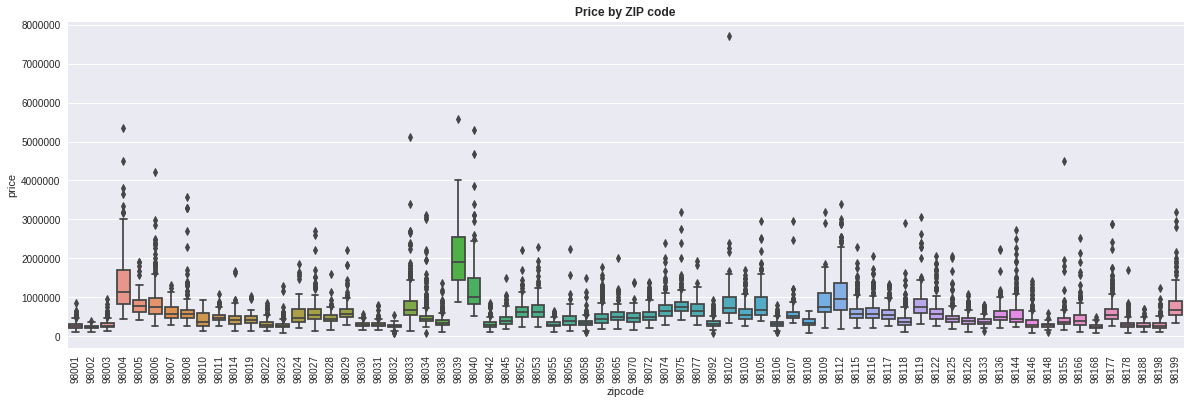

In [70]:
# Price distribution over zipcode
plt.figure(figsize=(20, 6))
sns.boxplot(x='zipcode', y='price', data=train_copy)
plt.xticks(rotation=90)
plt.title('Price by ZIP code', fontweight='bold')
plt.show()

Some zipcodes have higher pricing than others. Perhaps this data is captured by `lat` and `long`, but this feature acts as a concatenation of both.

### **New Features**
Here I'll add some new features and we'll see if it helps us predict house prices better.

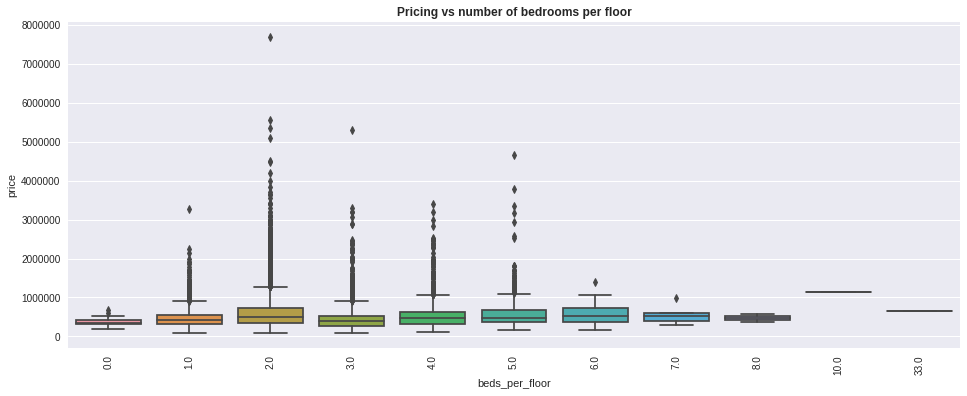

In [83]:
# Bedrooms per floor
train['beds_per_floor'] = np.round(train['bedrooms']/train['floors'])
plt.figure(figsize=(16, 6))
sns.boxplot(y='price', x='beds_per_floor', data=train)
plt.xticks(rotation=90)
plt.title('Pricing vs number of bedrooms per floor', fontweight='bold')
plt.show()

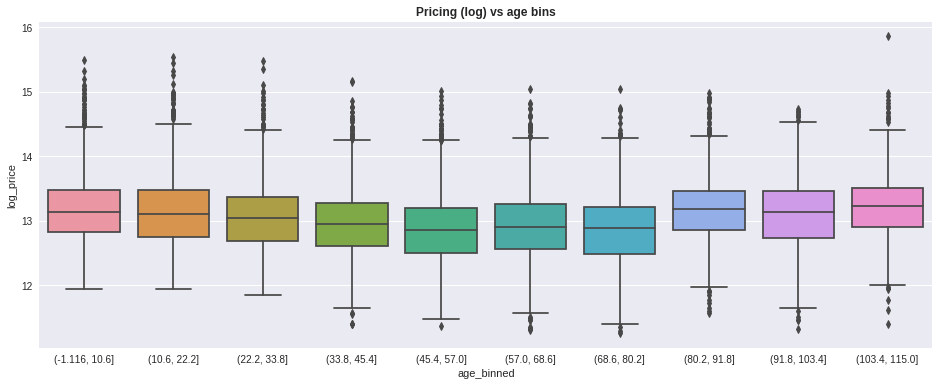

In [57]:
# Age of the house
train_copy['age'] = (train_copy['date'].dt.year - train_copy['yr_built']).astype('int')
train_copy['age_binned'] = pd.cut(train_copy['age'], 10)
train_copy['log_price'] = train_copy['price'].apply(np.log)
plt.figure(figsize=(16, 6))
sns.boxplot(y='log_price', x='age_binned', data=train_copy)
plt.title('Pricing (log) vs age bins', fontweight='bold')
plt.show()

Very new and very old houses are priced higher than those with in-between ages. **Also the first bin reveals that there are cases where the year in which the buiilding is built is in the future of the current date (negative date).** We cannot outright exclude these rows because there are rows with this behavior in test data as well. So we'll generate this feature, and hopefully the rows with negative values in train data will help the regressor predict for similar rows in test data.

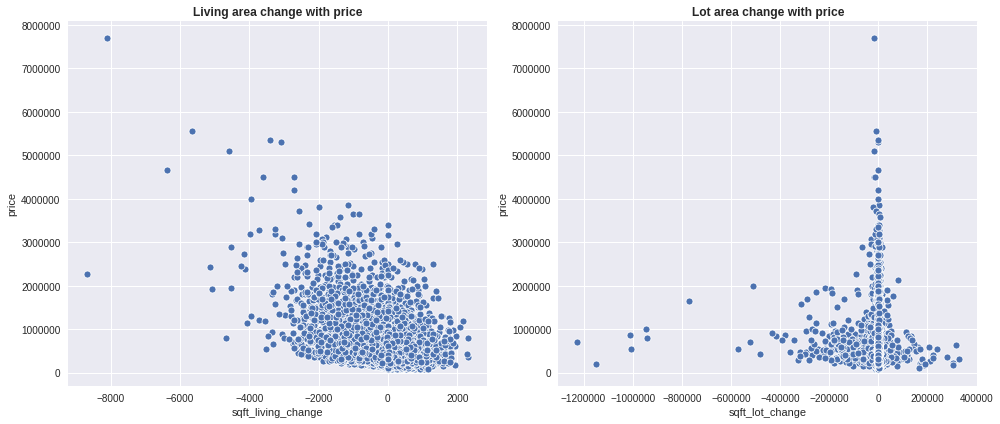

In [75]:
# Effect of change in living and lot area on price
train_copy['sqft_living_change'] = train_copy['sqft_living15'] - train_copy['sqft_living']
train_copy['sqft_lot_change'] = train_copy['sqft_lot15'] - train_copy['sqft_lot']

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.scatterplot(x='sqft_living_change', y='price', data=train_copy)
ax1.set_title('Living area change with price', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.scatterplot(x='sqft_lot_change', y='price', data=train_copy)
ax2.set_title('Lot area change with price', fontweight='bold')
plt.tight_layout()
plt.show()

It seems houses with reduction in living area have relatively higher prices. Maybe the deprecated area was used for development of other services which add more value to the house than simply having a lot of living space. Also houses with no change in lot area are priced higher than those whose lot areas changed. 

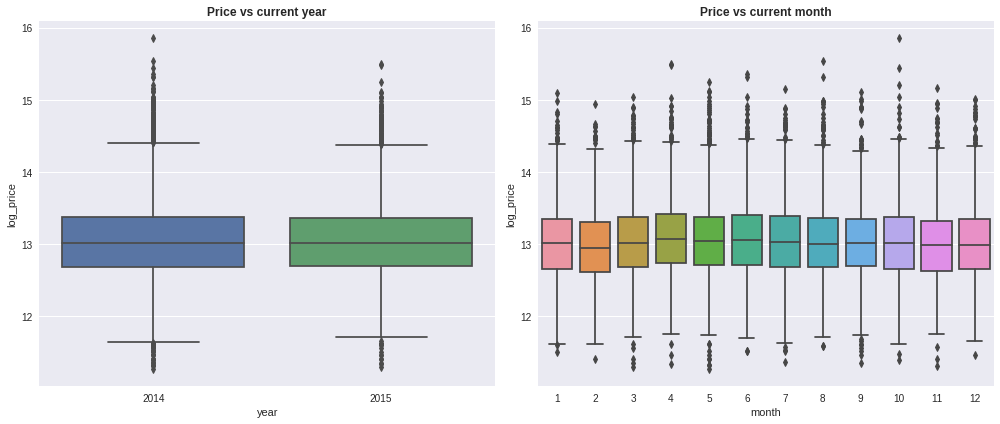

In [80]:
# Prices by year and month
train_copy['year'] = train_copy['date'].dt.year
train_copy['month'] = train_copy['date'].dt.month

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.boxplot(x='year', y='log_price', data=train_copy)
ax1.set_title('Price vs current year', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.boxplot(x='month', y='log_price', data=train_copy)
ax2.set_title('Price vs current month', fontweight='bold')
plt.tight_layout()
plt.show()

### **About feature distributions**
In this section I've commented on the distribution of some continuous features.

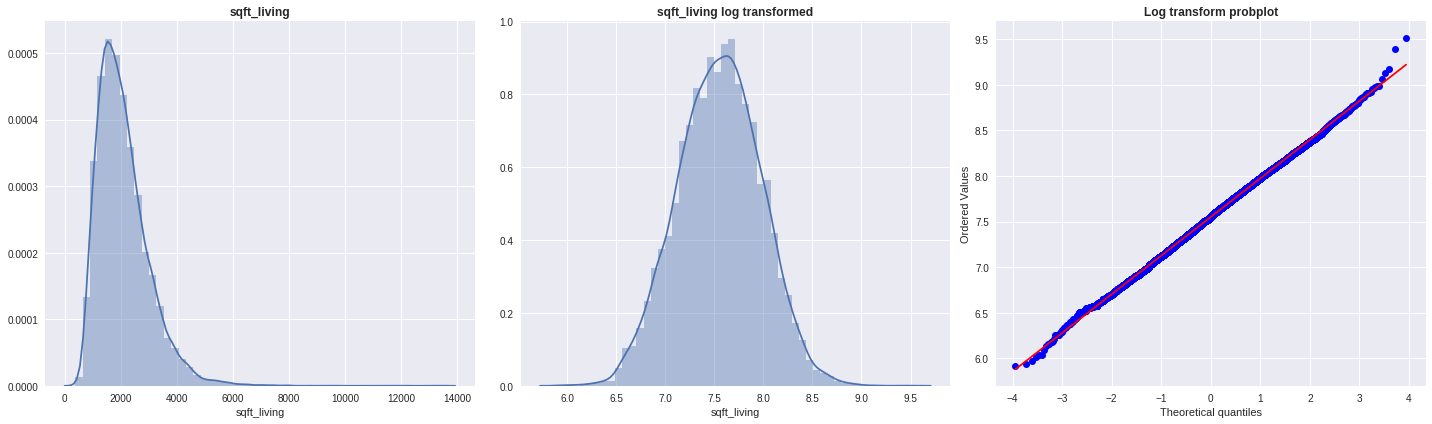

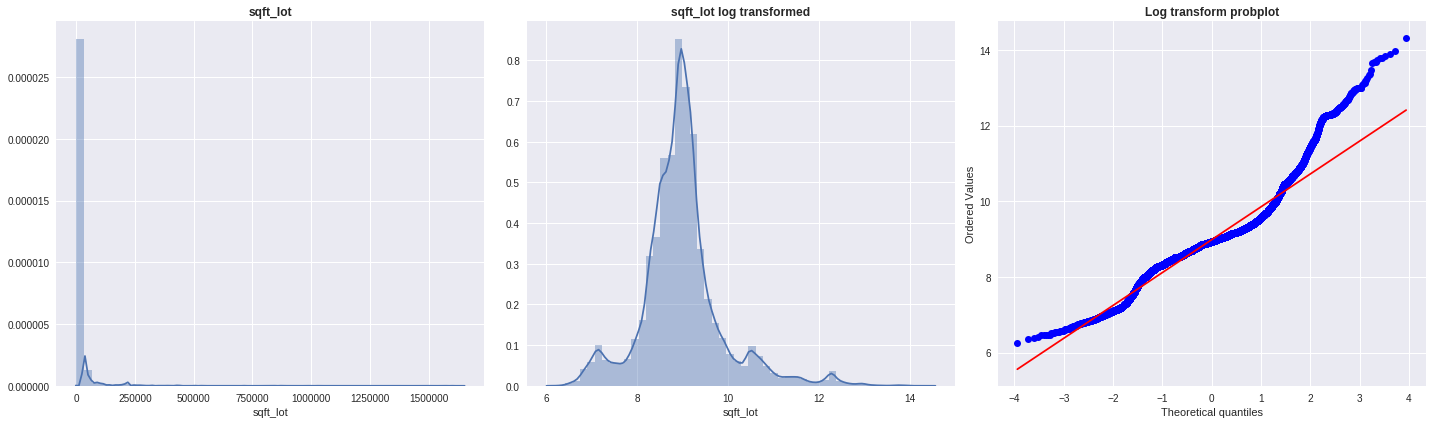

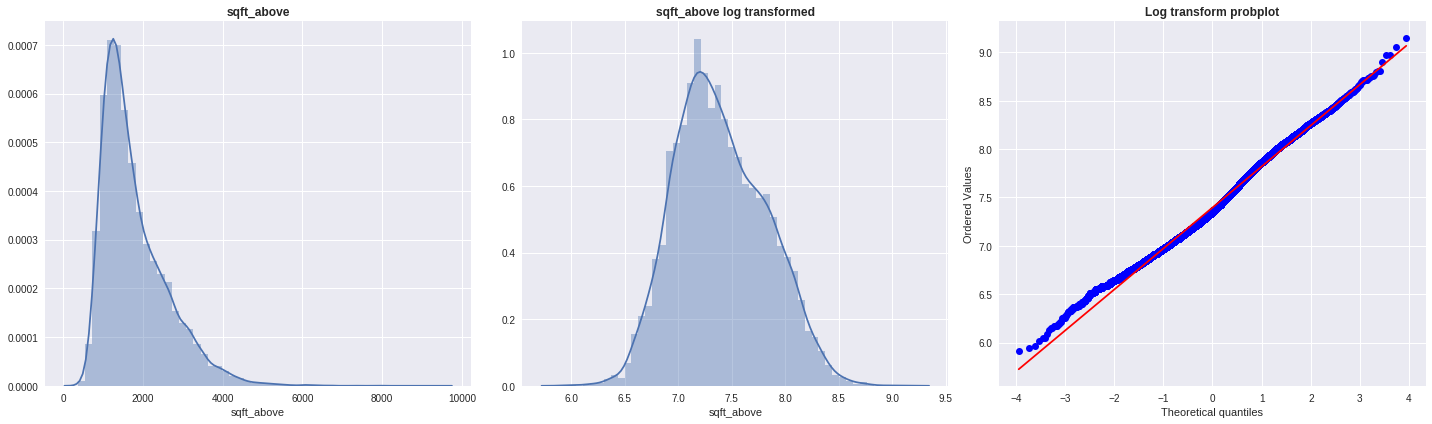

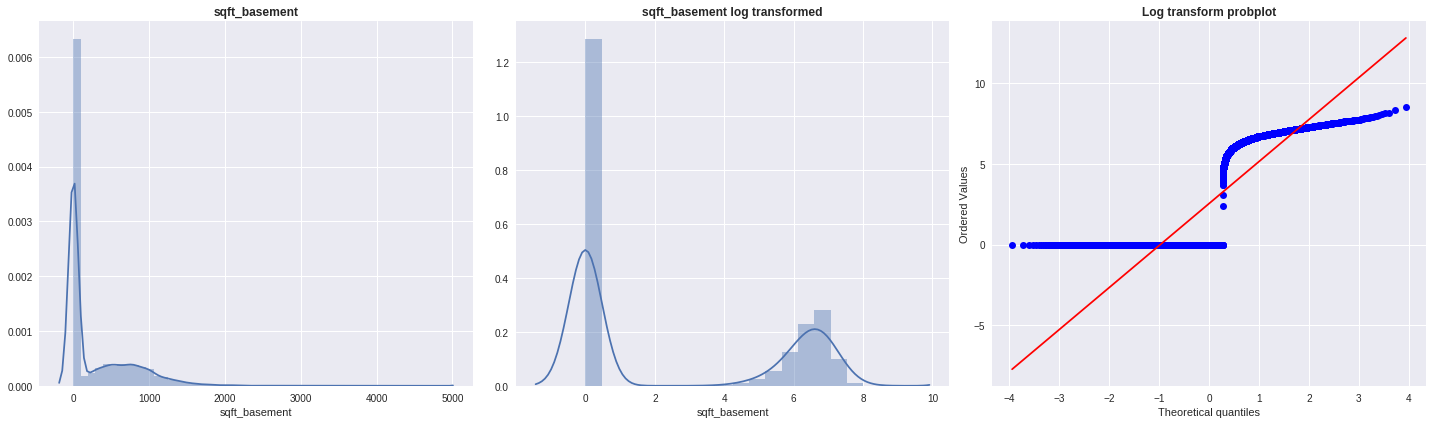

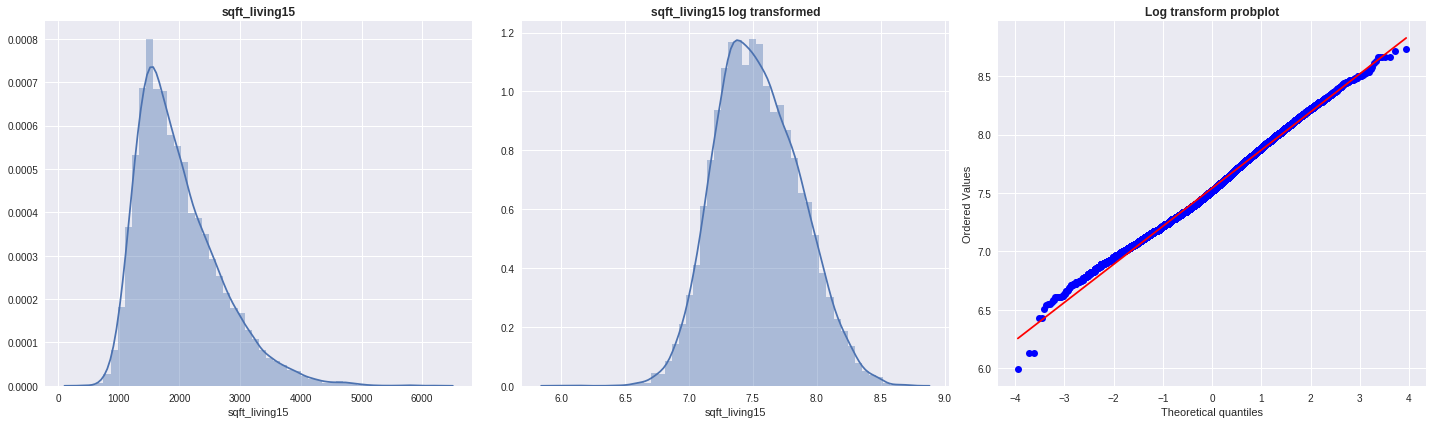

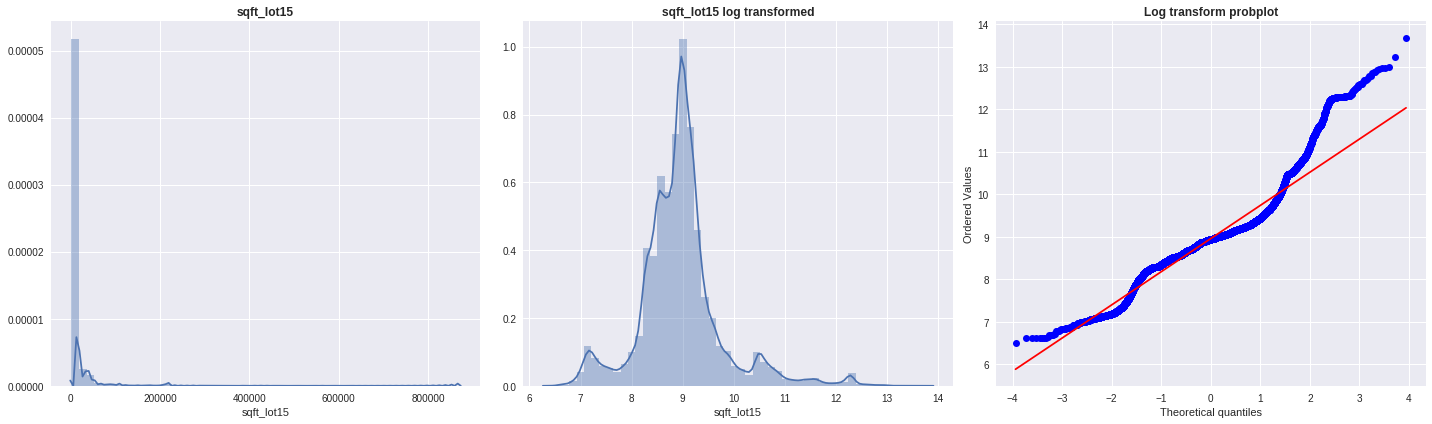

In [91]:
cont_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
             'sqft_living15', 'sqft_lot15']
for col in cont_cols:
    fig = plt.figure(figsize=(20, 6))
    ax1 = fig.add_subplot(131)
    sns.distplot(train[col], kde=True, hist=True)
    ax1.set_title(col, fontweight='bold')
    ax2 = fig.add_subplot(132)
    sns.distplot(train[col].apply(lambda x: np.log(x+1)), kde=True, hist=True)
    ax2.set_title(col + ' log transformed', fontweight='bold')
    ax3 = fig.add_subplot(133)
    probplot(train[col].apply(lambda x: np.log(x+1)), dist='norm', plot=plt)
    ax3.set_title('Log transform probplot', fontweight='bold')
    plt.tight_layout()
    plt.show()

Some models require than features be distributed normally; here is an attempt to normalize some continuous features. The probplots above reveal that most features come decently close to a normal disribution when log transformed, with the exception of `sqft_basement`. For that one, the disturbing factor is the enormous amount of zeros, or houses which (probably) do not have basements. For linear models, it would be best to convert this into a categorical feature: whether the house has a basement or not. We will use a gradient boosting machine here, so I have kept it as is. Since tree based models aren't really affected by feature distributions, I haven't transformed any other feature either to preserve their natural distribution (prevent variance shift or scaling).

## **Adding final features**
After all the analysis above, the features in this section have been added. I understand that not many good features were discovered above, and hopefully the model will do well with these features and the ones that are chosen out of the original set of features. Here is the list of features added.
1. Age of the house
2. Change in living area between 2015 and building year
3. Change in lot area between 2015 and building year
4. Month of recording
5. Year of recording
6. **KNN features**: If I were to go and purchase a house at some location, I would ask for prices of houses around to get an estimate of what this house might cost. These features attempt to capture that information. A KNN regressor is trained on training data prices using only `lat` and `long` as features (loosely utitlizing the heatmap generously shared by AC heads). This is then used to predict possible prices for train data itself as well as test data.

In [3]:
def add_features(df):
    df['age'] = (df['date'].dt.year - df['yr_built']).astype('int')
    df['sqft_living_delta'] = df['sqft_living15'] - df['sqft_living']
    df['sqft_lot_delta'] = df['sqft_lot15'] - df['sqft_lot']
    df['date_month'] = df['date'].dt.month
    df['date_year'] = df['date'].dt.year
    return df

def add_knn_estimate(df, df_train):
    X_train, y_train = df_train[['lat', 'long']], df_train['price']
    X = df[['lat', 'long']]
    for k in [20, 50, 70, 100]:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        df['local'+str(k)+'_price_estimate'] = knn.predict(X)
    return df

train = add_features(train)
test = add_features(test)
train = add_knn_estimate(train, train)
test = add_knn_estimate(test, train)

## **Models**
In this final section, I will show the model I built to generate my predictions. I haven't shown any hyperparameter tuning details as all of them were manually tuned. As to why XGBoost was chosen: gradient boosting machines are known to perform well on structured data (not always, but in general) especially when features have widely varying scales and categorical features have too many categories (making one-hot encoding a bad option). Since our data loosely fits into this picture, I decided to go ahead with it.

In [4]:
# Some columns will not be used for prediction
# Dropping them here
drop_cols = ['id', 'date']
test_ids = test['id'].values   # Preserving for final submission
train_data = train.drop(drop_cols, axis=1)
test_data = test.drop(drop_cols, axis=1)

In [5]:
# XGBoost does not have RMSLE internally defined
# Defined it here so I can use it to monitor progress with Python API
def RMSLE(preds, dmatrix):
    labels = dmatrix.get_label()
    diffs = np.log(preds + 1) - np.log(labels + 1)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('RMSLE', np.sqrt(avg))

In [6]:
# KFold cross validation
# XGBoost with configuration that gave me best performance
# I didn't use random state earlier so I'm not sure if it'll ...
# ... converge to the same local minimum
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.03,
    'max_depth': 11,
    'reg_lambda': 100.0,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'random_state': 42
}

X, y = train_data.drop('price', axis=1), train_data['price']
kf = KFold(n_splits=3)
val_scores = []

for train_idx, val_idx in kf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    d_train = xgb.DMatrix(data=X_train, label=y_train)
    d_val = xgb.DMatrix(data=X_val, label=y_val)
    model = xgb.train(
        xgb_params, d_train,
        evals = [(d_train, 'Train'), (d_val, 'Val')],
        feval = RMSLE,
        maximize = False,
        num_boost_round = 100000,
        verbose_eval = 100,
        early_stopping_rounds = 500
    )
    val_preds = model.predict(d_val)
    score = mean_squared_log_error(y_val, val_preds)**0.5
    val_scores.append(score)
    print('\n')
    
print("Validation scores: {}".format(val_scores))
print("Average validation RMSLE: {:.5f}".format(np.mean(val_scores)))

[0]	Train-rmse:639610.50000	Val-rmse:632149.43750	Train-RMSLE:3.54529	Val-RMSLE:3.53762
Multiple eval metrics have been passed: 'Val-RMSLE' will be used for early stopping.

Will train until Val-RMSLE hasn't improved in 500 rounds.
[100]	Train-rmse:178230.79688	Val-rmse:194905.59375	Train-RMSLE:0.18330	Val-RMSLE:0.19826
[200]	Train-rmse:133131.15625	Val-rmse:158046.20312	Train-RMSLE:0.14884	Val-RMSLE:0.17401
[300]	Train-rmse:114379.91406	Val-rmse:143428.40625	Train-RMSLE:0.13746	Val-RMSLE:0.16785
[400]	Train-rmse:102356.53906	Val-rmse:134821.64062	Train-RMSLE:0.13046	Val-RMSLE:0.16477
[500]	Train-rmse:93626.03125	Val-rmse:129122.86719	Train-RMSLE:0.12465	Val-RMSLE:0.16300
[600]	Train-rmse:86916.98438	Val-rmse:125470.69531	Train-RMSLE:0.11979	Val-RMSLE:0.16193
[700]	Train-rmse:81542.37500	Val-rmse:123284.37500	Train-RMSLE:0.11553	Val-RMSLE:0.16140
[800]	Train-rmse:77035.29688	Val-rmse:121329.05469	Train-RMSLE:0.11134	Val-RMSLE:0.16094
[900]	Train-rmse:73050.55469	Val-rmse:119790.61719	T

In [7]:
# Generating prediction file
d_train = xgb.DMatrix(data=X, label=y)
d_test = xgb.DMatrix(data=test_data)

model = xgb.train(
        xgb_params, d_train,
        feval = RMSLE,
        maximize = False,
        num_boost_round = 1200,
    )

test_preds = model.predict(d_test)
sub_df = pd.DataFrame(np.vstack((test_ids, test_preds)).T, columns=['id', 'price'])
sub_df['id'] = sub_df['id'].astype('int')
sub_df.to_csv('.././data/submission_XGB.csv', index=False)

### **Feature Importances**
Now that XGBoost has been trained, let's see how much each feature was useful.

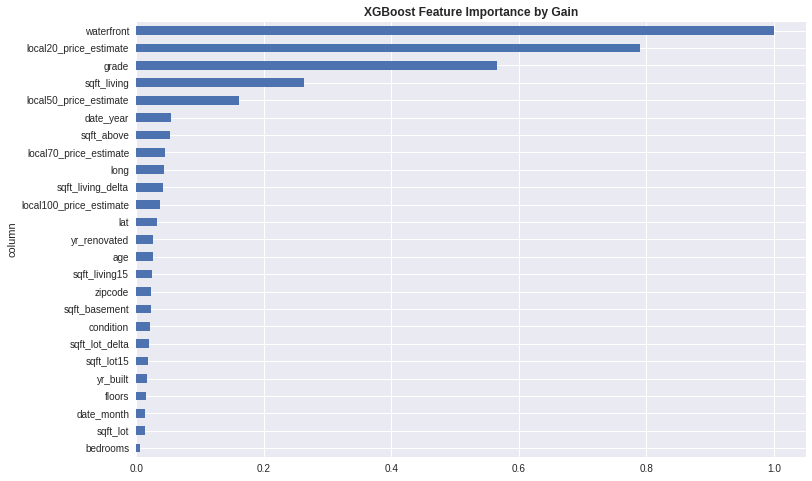

In [118]:
imp_dict = model.get_score(importance_type='gain')
imp_dict = {k: v/max(list(imp_dict.values())) for (k, v) in imp_dict.items()}
cols = np.array(list(imp_dict.keys()))
imps = np.array(list(imp_dict.values()))
imp_df = pd.DataFrame(np.vstack((cols, imps)).T, columns=['column', 'importance_ratio'])
imp_df['importance_ratio'] = imp_df['importance_ratio'].astype('float')

# Plot
imp_df.set_index('column')['importance_ratio'].sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('XGBoost Feature Importance by Gain', fontweight='bold')
plt.show()

Two of the features we created, KNN estimates at 20 and 50 neighbors, have been helpful in prediction. So decent feature engineering I guess. :)

### **LightGBM with categorical features**
For experimental purposes only.

In [13]:
cat_fs = ['date_month', 'date_year', 'zipcode']

# LightGBM
lgb_params = {
    'objective': 'regression',
    'learning_rate': 0.03,
    'max_depth': 11,
    'reg_lambda': 100.0,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'random_state': 42,
}

X, y = train_data.drop('price', axis=1), train_data['price']
kf = KFold(n_splits=3)
val_scores = []

for train_idx, val_idx in kf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    d_train = lgb.Dataset(data=X_train, label=y_train, categorical_feature=cat_fs)
    d_val = lgb.Dataset(data=X_val, label=y_val, categorical_feature=cat_fs)
    model = lgb.train(
        lgb_params, d_train,
        valid_sets = [d_train, d_val],
        num_boost_round = 100000,
        verbose_eval = 100,
        early_stopping_rounds = 500
    )
    val_preds = model.predict(X_val)
    score = mean_squared_log_error(y_val, val_preds)**0.5
    val_scores.append(score)
    print('\n')
    
print("Validation scores: {}".format(val_scores))
print("Average validation RMSLE: {:.5f}".format(np.mean(val_scores)))

/home/nishant/.local/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[100]	training's l2: 2.21613e+10	valid_1's l2: 2.84542e+10
[200]	training's l2: 1.38451e+10	valid_1's l2: 1.9808e+10
[300]	training's l2: 1.08622e+10	valid_1's l2: 1.65538e+10
[400]	training's l2: 9.21183e+09	valid_1's l2: 1.51585e+10
[500]	training's l2: 8.11674e+09	valid_1's l2: 1.4404e+10
[600]	training's l2: 7.34891e+09	valid_1's l2: 1.3911e+10
[700]	training's l2: 6.74946e+09	valid_1's l2: 1.35948e+10
[800]	training's l2: 6.25598e+09	valid_1's l2: 1.33868e+10
[900]	training's l2: 5.82762e+09	valid_1's l2: 1.32133e+10
[1000]	training's l2: 5.44009e+09	valid_1's l2: 1.30772e+10
[1100]	training's l2: 5.09697e+09	valid_1's l2: 1.2982e+10
[1200]	training's l2: 4.80473e+09	valid_1's l2: 1.29107e+10
[1300]	training's l2: 4.53097e+09	valid_1's l2: 1.28443e+10
[1400]	training's l2: 4.30462e+09	valid_1's l2: 1.27758e+10
[1500]	training's l2: 4.09385e+09	valid_1's l2: 1.27187e+10
[1600]	training's l2: 3.89306e+09	valid_1's l2: 1.2

/home/nishant/.local/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	training's l2: 1.33383e+10	valid_1's l2: 1.98354e+10
[300]	training's l2: 1.02408e+10	valid_1's l2: 1.69449e+10
[400]	training's l2: 8.58013e+09	valid_1's l2: 1.55889e+10
[500]	training's l2: 7.52138e+09	valid_1's l2: 1.483e+10
[600]	training's l2: 6.72739e+09	valid_1's l2: 1.44517e+10
[700]	training's l2: 6.07746e+09	valid_1's l2: 1.42336e+10
[800]	training's l2: 5.54395e+09	valid_1's l2: 1.41196e+10
[900]	training's l2: 5.068e+09	valid_1's l2: 1.39429e+10
[1000]	training's l2: 4.66784e+09	valid_1's l2: 1.38534e+10
[1100]	training's l2: 4.34917e+09	valid_1's l2: 1.38123e+10
[1200]	training's l2: 4.05615e+09	valid_1's l2: 1.37598e+10
[1300]	training's l2: 3.80712e+09	valid_1's l2: 1.37284e+10
[1400]	training's l2: 3.59091e+09	valid_1's l2: 1.37272e+10
[1500]	training's l2: 3.39829e+09	valid_1's l2: 1.37244e+10
[1600]	training's l2: 3.21145e+09	valid_1's l2: 1.37259e+10
[1700]	training's l2: 3.04889e+09	valid_1's l2: 1.37351e+10
[1800]	training's l2: 2.89358e+09	valid_1's l2: 1.37

/home/nishant/.local/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	training's l2: 1.46214e+10	valid_1's l2: 1.52271e+10
[300]	training's l2: 1.11176e+10	valid_1's l2: 1.3786e+10
[400]	training's l2: 9.34741e+09	valid_1's l2: 1.31934e+10
[500]	training's l2: 8.17731e+09	valid_1's l2: 1.29941e+10
[600]	training's l2: 7.31962e+09	valid_1's l2: 1.29283e+10
[700]	training's l2: 6.64322e+09	valid_1's l2: 1.29165e+10
[800]	training's l2: 6.11056e+09	valid_1's l2: 1.29046e+10
[900]	training's l2: 5.65943e+09	valid_1's l2: 1.28571e+10
[1000]	training's l2: 5.26925e+09	valid_1's l2: 1.28568e+10
[1100]	training's l2: 4.93937e+09	valid_1's l2: 1.28672e+10
[1200]	training's l2: 4.63047e+09	valid_1's l2: 1.28862e+10
[1300]	training's l2: 4.3453e+09	valid_1's l2: 1.28923e+10
[1400]	training's l2: 4.10132e+09	valid_1's l2: 1.29035e+10
Early stopping, best iteration is:
[924]	training's l2: 5.55641e+09	valid_1's l2: 1.28477e+10


Validation scores: [0.16193894657080113, 0.16363528192541651, 0.15592445584051123]
Average validation RMSLE: 0.16050


In [17]:
# Generating prediction file
d_train = lgb.Dataset(data=X, label=y, categorical_feature=cat_fs)

model = lgb.train(
        lgb_params, d_train,
        num_boost_round = 1200,
    )

test_preds = model.predict(test_data)
sub_df = pd.DataFrame(np.vstack((test_ids, test_preds)).T, columns=['id', 'price'])
sub_df['id'] = sub_df['id'].astype('int')
sub_df.to_csv('submission_LGB.csv', index=False)

## **Why the long face?**
My ranking in the private leaderboard was quite bad compared to the public leaberboard. Let's see if I can find out what happened. I'm going to check whether the predictions made by my model are following the distributions we saw earlier.

In [11]:
# Integrate predictions in test file
test['price'] = test_preds

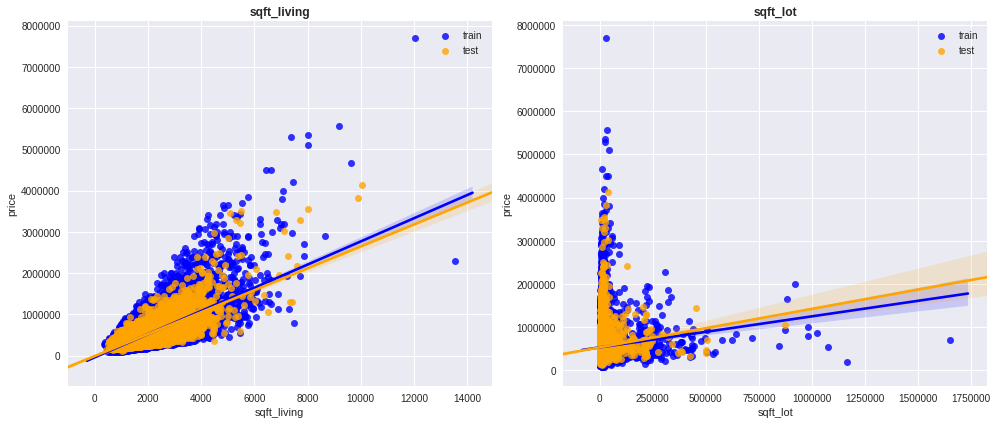

In [14]:
# Living area and lot area versus price
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.regplot(x='sqft_living', y='price', data=train, color='blue', label='train')
sns.regplot(x='sqft_living', y='price', data=test, color='orange', label='test')
ax1.set_title('sqft_living', fontweight='bold')
ax1.legend()
ax2 = fig.add_subplot(122)
sns.regplot(x='sqft_lot', y='price', data=train, color='blue', label='train')
sns.regplot(x='sqft_lot', y='price', data=test, color='orange', label='test')
ax2.set_title('sqft_lot', fontweight='bold')
ax2.legend()
plt.tight_layout()
plt.show()

Seems fine here, only the regression uncertainty for lot area is slightly higher for our predictions that in the training data.

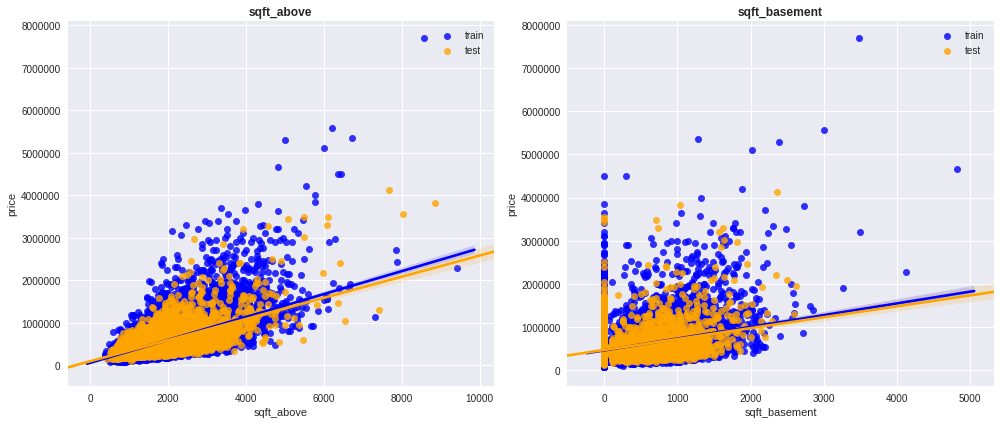

In [16]:
# Above and basement areas
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.regplot(x='sqft_above', y='price', data=train, color='blue', label='train')
sns.regplot(x='sqft_above', y='price', data=test, color='orange', label='test')
ax1.set_title('sqft_above', fontweight='bold')
ax1.legend()
ax2 = fig.add_subplot(122)
sns.regplot(x='sqft_basement', y='price', data=train, color='blue', label='train')
sns.regplot(x='sqft_basement', y='price', data=test, color='orange', label='test')
ax2.set_title('sqft_basement', fontweight='bold')
ax2.legend()
plt.tight_layout()
plt.show()

A few spurious predictions here and there but nothing unusual here either.

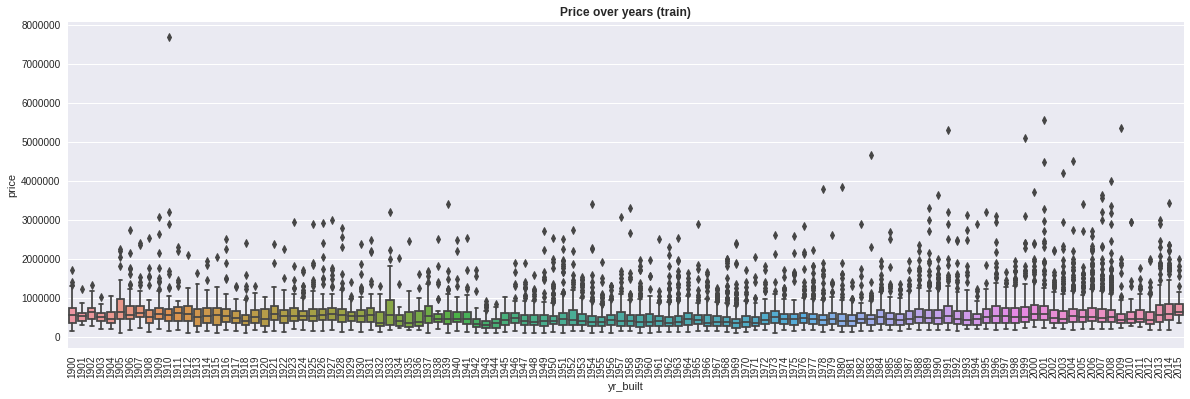

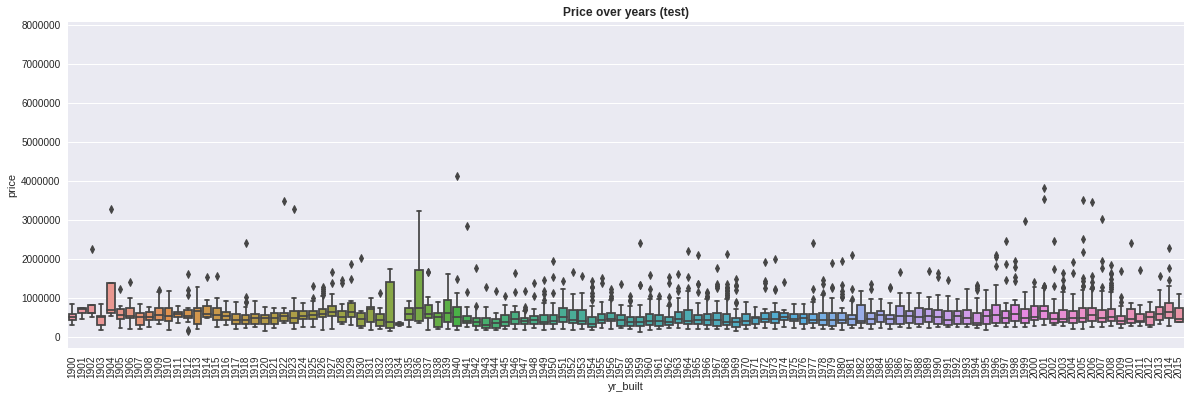

In [18]:
# Price variation along years
plt.figure(figsize=(20, 6))
sns.boxplot(y='price', x='yr_built', data=train)
plt.xticks(rotation=90)
plt.title('Price over years (train)', fontweight='bold')
plot1_lim = plt.ylim()
plt.show()

plt.figure(figsize=(20, 6))
sns.boxplot(y='price', x='yr_built', data=test)
plt.ylim(plot1_lim)
plt.xticks(rotation=90)
plt.title('Price over years (test)', fontweight='bold')
plt.show()

**Here's something interesting.** Turns out our model has given high prices to some old houses, which is unlike the distribution in train data. Perhaps this is the cause of the problem? Let's see if we can find more clues. 

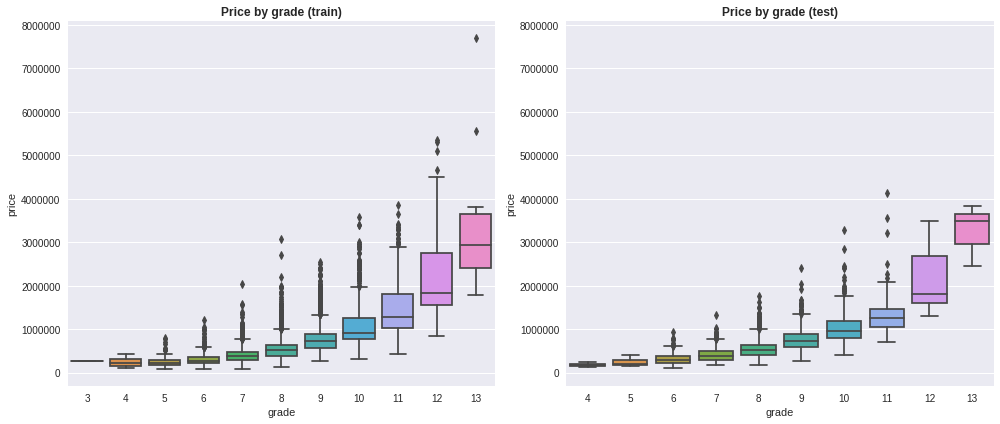

In [21]:
# Price by grade
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.boxplot(y='price', x='grade', data=train)
ax1.set_title('Price by grade (train)', fontweight='bold')
plot1_lim = ax1.get_ylim()
ax2 = fig.add_subplot(122)
sns.boxplot(y='price', x='grade', data=test)
ax2.set_title('Price by grade (test)', fontweight='bold')
ax2.set_ylim(plot1_lim)
plt.tight_layout()
plt.show()

Not too bad but the distribution of prices with grade is also slightly disturbed near the higher grades.

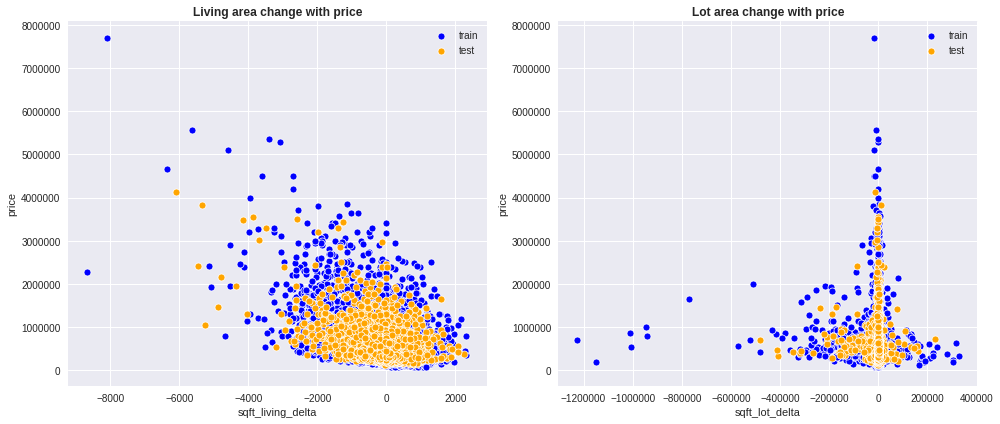

In [23]:
# Change in living and lot area with price
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.scatterplot(x='sqft_living_delta', y='price', data=train, color='blue', label='train')
sns.scatterplot(x='sqft_living_delta', y='price', data=test, color='orange', label='test')
ax1.set_title('Living area change with price', fontweight='bold')
ax1.legend()
ax2 = fig.add_subplot(122)
sns.scatterplot(x='sqft_lot_delta', y='price', data=train, color='blue', label='train')
sns.scatterplot(x='sqft_lot_delta', y='price', data=test, color='orange', label='test')
ax2.set_title('Lot area change with price', fontweight='bold')
ax2.legend()
plt.tight_layout()
plt.show()

Seems okay here as well.

### Conclusion (maybe)
I think it's because of the disturbed distribution in prices with `yr_built` which is the source of this problem. As to what can be done to solve this, I'm still thinking...